In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from os import listdir
from os.path import isfile, join
%matplotlib inline

In [2]:
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
        
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = []
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times.append(reaction_time)
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [6]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]))
    log_s_j_x.append([np.log(j.seconds) for j in s_j_x])
fake_logs = [[1 for i in range(num_root_tweets)] for j in range(5)]

In [15]:
type(log_s_j_x[0][1])

numpy.float64

In [7]:
# pymc3 model 
with pm.Model() as twitter_model:
    # global model parameters
    # Time-related hyperparameters
    alpha = pm.Normal('alpha', mu=0, sd=100) #eq 5
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2) # eq 6
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10) # eq 7
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002) # eq 8
    
    # binom model for graph structure
    beta_0 = pm.Normal('beta_0', mu=0, sd=100) # eq 12
    beta_F = pm.Normal('beta_F', mu=0, sd=100) # eq 13
    beta_d = pm.Normal('beta_d', mu=0, sd=100) # eq 14
    sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000) # eq 15
    
    a_tau = pm.Deterministic('a_tau', pm.math.exp(log_a_tau))
    
    # tweet specific parameters, keyed by tweet x
    t_x_dict = {}
    a_x_dict = {}
    log_s = {}
    M_dict = {}
    b_dict = {}
    likelihood_training_tweets = {}
    
    for x in range(2): # num_root_tweets
        # setting up observed data
        tweet_df = tweet_dfs[x]
        log_s = [np.log(i.seconds) for i in generate_reaction_times(tweet_df)]
        tweet_df_users = list(tweet_df['UserId'])
        num_followers = generate_number_of_follower_who_retweet(tweet_df)
        
        # log-normal model for reaction times
        t_x_dict[x] = pm.InverseGamma('tau_{}_squared'.format(x), alpha=a_tau, beta=b_tau) # eq 4
        a_x_dict[x] = pm.Normal('alpha_{}'.format(x), mu=alpha, tau=1/sigma_squared_delta) # eq 3
        # log_s[x] = pm.Normal('log_s_{}'.format(x), mu=a_x_dict[x], tau=1/t_x_dict[x], observed=log_s) # eq 2
        log_s[x] = {}
        
        # binomial model for retweet graph structure
        M_dict[x] = {}
        b_dict[x] = {}
        
        for j, row in tweet_dfs[x].iterrows():
            if j > 10: 
                break # try for performance reasons
            f_j_x = int(row['FollowerCount']) 
            d_j_x = row['DistanceFromRoot']
            mu_j_x = pm.Deterministic('mu_{}_{}'.format(x,j), 
                    beta_0 + beta_F*pm.math.log(f_j_x + 1) + beta_d*pm.math.log(d_j_x + 1)) # eq 11
            logit_b_j_x = pm.Normal('logit_b_{}_{}'.format(x,j), mu=mu_j_x, tau=1/sigma_squared_b) # eq 10
            
            b_dict[x][j] = pm.Deterministic('b_{}_{}'.format(x,j), pm.math.invlogit(logit_b_j_x))
            
            M_dict[x][j] = pm.Binomial('M_{}_{}'.format(x, j), n = f_j_x, p = b_dict[x][j], observed=num_followers[tweet_df_users[j]]) # eq 9
            
            log_s[x][j] = pm.Normal('log_s_{}_{}'.format(x, j), mu=a_x_dict[x], tau=t_x_dict[x]**0.5, observed=log_s_j_x[x][j]) # eq 2
        
#         # likelihood of observation
#         likelihood_training_tweets[x] = M_dict[x][0]
#         for j in range(1, len(tweet_dfs[x])): # len(tweet_dfs[x])
#             likelihood_training_tweets[x] *= (log_s[x][j] * M_dict[x][j])
        
#         temp = pm.Deterministic('obs_likelihood_{}'.format(x), likelihood_training_tweets[x])


In [ ]:
# run model
with twitter_model:
    trace = pm.sample(1000,tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logit_b_1_10, logit_b_1_9, logit_b_1_8, logit_b_1_7, logit_b_1_6, logit_b_1_5, logit_b_1_4, logit_b_1_3, logit_b_1_2, logit_b_1_1, logit_b_1_0, alpha_1, tau_1_squared_log__, logit_b_0_10, logit_b_0_9, logit_b_0_8, logit_b_0_7, logit_b_0_6, logit_b_0_5, logit_b_0_4, logit_b_0_3, logit_b_0_2, logit_b_0_1, logit_b_0_0, alpha_0, tau_0_squared_log__, sigma_squared_b_log__, beta_d, beta_F, beta_0, b_tau_log__, log_a_tau, sigma_squared_delta_log__, alpha]
 42%|████▏     | 840/2000 [02:34<03:33,  5.44it/s]

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


beta_0: -28.1453862526(63.7483241683)
beta_F: 1.15377397563(4.28704115041)
beta_d: -87.4991789206(66.4658626664)
alpha: 4.95063914575(0.719669984333)
sigma_squared_delta: 1.13709581723(1.04464428218)


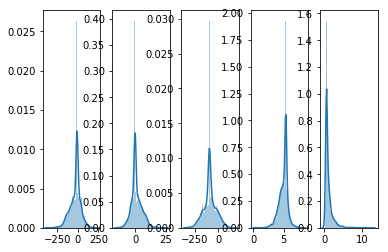

In [26]:
# printing 
with twitter_model:
    imp_dists = ['beta_0', 'beta_F', 'beta_d', 'alpha', 'sigma_squared_delta']
#                 'beta_0', 'beta_F', 'beta_d']
    fig, axs = plt.subplots(ncols=len(imp_dists))
    for i in range(len(imp_dists)):
        var = imp_dists[i]
        sns.distplot(trace[var], ax=axs[i]);
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")


In [23]:
with twitter_model:
    print(trac)

AttributeError: 'MultiTrace' object has no attribute 'variables'